In [1]:
import numpy as np

import torch
import torch.nn as nn
import pandas
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from matplotlib.pylab import plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
discharge_capacities = np.load(r"./Datasets/discharge_capacity.npy", allow_pickle=True)
discharge_capacities = discharge_capacities.tolist()

In [3]:
discharge_capacities[0]

[array([0.        , 1.0706892 , 1.0719005 , ..., 0.88462406, 0.88433141,
        0.88280821]),
 array([0.        , 0.01674235, 0.01672431, ..., 0.0181332 , 0.0181233 ,
        0.0181211 ]),
 array([0.        , 1.0710422 , 1.0716741 , ..., 0.88449496, 0.88432896,
        0.8840425 ]),
 array([ 0.        , 31.87501078, 31.93149033, ..., 32.70054223,
        32.99059246, 32.96182749]),
 array([ 0.      , 29.56613 , 29.604385, ..., 30.243074, 30.337559,
        30.634762]),
 array([ 0.      , 35.652016, 35.692978, ..., 36.786781, 36.923153,
        36.535774]),
 array([ 0.        , 13.34125   , 13.42577667, ..., 17.04515833,
        17.15257333, 17.35889667])]

In [4]:
channels  = 7

In [5]:

def get_data(discharge_capacities,percentage,window_size,stride,channels,type):

    train_data =[]
    FPC_data  =[]
    name = 0
    test_data = []
    
    if(type == "train"):
        
        for battery in discharge_capacities:
            a = len(FPC_data)
            battery = np.asarray(battery)
            
            battery_name = 'battery' + str(name)
            name = name+1
            
            # Taking inital x% as input and giving the output as 1
            i= 0
            target = 1
            while(i+stride+window_size <= int(percentage*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:channels,i:i+window_size], target,battery_name ))
                i = i+stride

            # Taking inputs in the middle for FPC
            i = int(percentage*len(battery[0]))
            target = -1
            while(i+stride+window_size <= int((1-percentage)*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                FPC_data.append((battery[:channels,i:i+window_size], target,battery_name))
                i = i+stride

            # Taking last x% as input and giving the output as 0
            i = int((1-percentage)*len(battery[0]))
            target = 0
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:channels,i:i+window_size], target ,battery_name))
                i = i+stride
            # print(len(FPC_data)-a, len(battery[0]), len(FPC_data)-a- .90*len(battery[0]))

        return train_data,FPC_data

    else:
        name = 100
        for battery in discharge_capacities:
            battery = np.asarray(battery)
            i= 0
            
            battery_name = 'test_battery' + str(name)
            name = name+1
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                test_data.append((battery[:channels,i:i+window_size], 1,battery_name))
                i = i+stride

        return test_data


In [6]:
class battery_dataloader(Dataset):
    
    def __init__(self,data):
        self.data = data
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        inp =  torch.tensor(self.data[idx][0]).float()
        output = torch.tensor(self.data[idx][1]).float()
        name = self.data[idx][2]
        return inp, output,name 
   


In [7]:
percentage  = 0.10  # 5 percent data
window_size = 50    # window size
stride = 1          # stride

train_data,FPC_data = get_data(discharge_capacities[:100],percentage,window_size,stride,channels,type = "train")
test_data  = get_data(discharge_capacities[100:],None,window_size,stride,channels,type= "test")

obj_train  = battery_dataloader(train_data)
obj_FPC  = battery_dataloader(FPC_data)
obj_test  = battery_dataloader(test_data)


train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)


In [8]:

print("Number of Channels  :", channels)
print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)
print("Shape of a batch    :",next(iter(train_dataloader))[1].shape)


Number of Channels  : 7
Shape of a batch    : torch.Size([8, 7, 50])
Shape of a batch    : torch.Size([8])


In [9]:
import math
class CNN_Model(nn.Module):
    
    def __init__(self,input_size, channels):
        super(CNN_Model, self).__init__()
        self.name = "CNN"
        filter_size_1 = 21
        filter_size=21
        
        self.conv1 = nn.Conv1d(channels,16,kernel_size = filter_size_1, stride=1,padding=filter_size_1//2)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.max_pool1 = nn.MaxPool1d(2)
        

        self.conv2 = nn.Conv1d(16,32, kernel_size = filter_size_1, stride = 1,padding=filter_size_1 //2)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.max_pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32,64, kernel_size = filter_size, stride = 1,padding=filter_size //2)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.max_pool3 = nn.MaxPool1d(2)

       
        self.flatten_size = 128*math.floor(input_size/(2*2*2*2))
        self.flatten = nn.Flatten(start_dim=1)
        
        self.Linear1 = nn.Linear(self.flatten_size, input_size)
        self.batch_norm_linear = nn.BatchNorm1d(input_size)
        # self.a = nn.Linear()
        self.Linear2 = nn.Linear(input_size,1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)
        # print(self.flatten_size)
        
        
        
    def forward(self,x):
        # x= x.view(x.shape[0],1,x.shape[1])
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.max_pool2(out)   

        out = self.conv3(out)
        out = self.relu(out)
        out = self.batch_norm3(out)
        out = self.dropout(out)
        out = self.max_pool3(out) 

        out = self.flatten(out)
        
        out = self.Linear1(out)  
        out = self.Linear2(out)

        out = self.sigmoid(out)
        return out

In [10]:
from torchmetrics.classification import BinaryAccuracy


def train_model(window_size,channels,train_dataloader,epochs):

    model = CNN_Model(window_size,channels)
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
    criterion = nn.BCELoss()
    metric = BinaryAccuracy()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

   

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        model.requires_grad_(True)
        acc = 0
        total_loss = 0
        total = 0
        total_batches = 0
        for x, y ,_ in train_dataloader:
            
            x = x.to(device=device)
            y = y.to(device=device)
            out = model(x)
            acc += metric(out, y.unsqueeze(1))

            loss = criterion(out,y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size()[0]
            total += x.size()[0]
            total_batches +=1


        print("Loss = {} Accuarcy ={}".format(total_loss/total,acc/total_batces))
    return model



In [11]:
model = train_model(window_size, channels,train_dataloader,20) 

Loss = 0.17952384037967928 Accuarcy =0.923559844493866
Loss = 0.06134328925112931 Accuarcy =0.9830132722854614
Loss = 0.03592715145410072 Accuarcy =0.9894756078720093
Loss = 0.05907026866477198 Accuarcy =0.9889217019081116
Loss = 0.06354556191723632 Accuarcy =0.988552451133728
Loss = 0.028183535821861033 Accuarcy =0.994276225566864
Loss = 0.03959873046451613 Accuarcy =0.9911373853683472
Loss = 0.02888588798108138 Accuarcy =0.9922451972961426
Loss = 0.03890760189302744 Accuarcy =0.9913219809532166
Loss = 0.01156238203524601 Accuarcy =0.9970458149909973
Loss = 0.029161950482654134 Accuarcy =0.9931684136390686
Loss = 0.024824164786547448 Accuarcy =0.9940915703773499
Loss = 0.023476403668425187 Accuarcy =0.9920605421066284
Loss = 0.009011279691985345 Accuarcy =0.9977843165397644
Loss = 0.039603630568714486 Accuarcy =0.9931684136390686
Loss = 0.003071170950146844 Accuarcy =0.9992614388465881
Loss = 0.019107854872308854 Accuarcy =0.9957533478736877
Loss = 0.020339155898358868 Accuarcy =0.995

In [12]:
# def get_fpc_window(pred):
#     initial = pred[0]
#     window = -1
#     for i in range(0,len(pred)-1):
#         if(pred[i+1]!=initial):
#             window =i
#         initial = pred[i+1]
#     return window+1


def get_fpc_window(pred,patiance):
    
    count = 0
    for window,pred_value in enumerate(pred):
        if(pred_value.item() ==0):
            count =  count +1
        if(pred_value.item() ==1):
            count =0
        if(window == len(pred)-1):
            change_index = window-count
            return change_index,[1.0 if i<change_index else 0.0 for i in range(len(pred))]
        if(count == patiance):
            change_index = window - patiance
            return change_index,[1.0 if i<change_index else 0.0 for i in range(len(pred))]
    
        

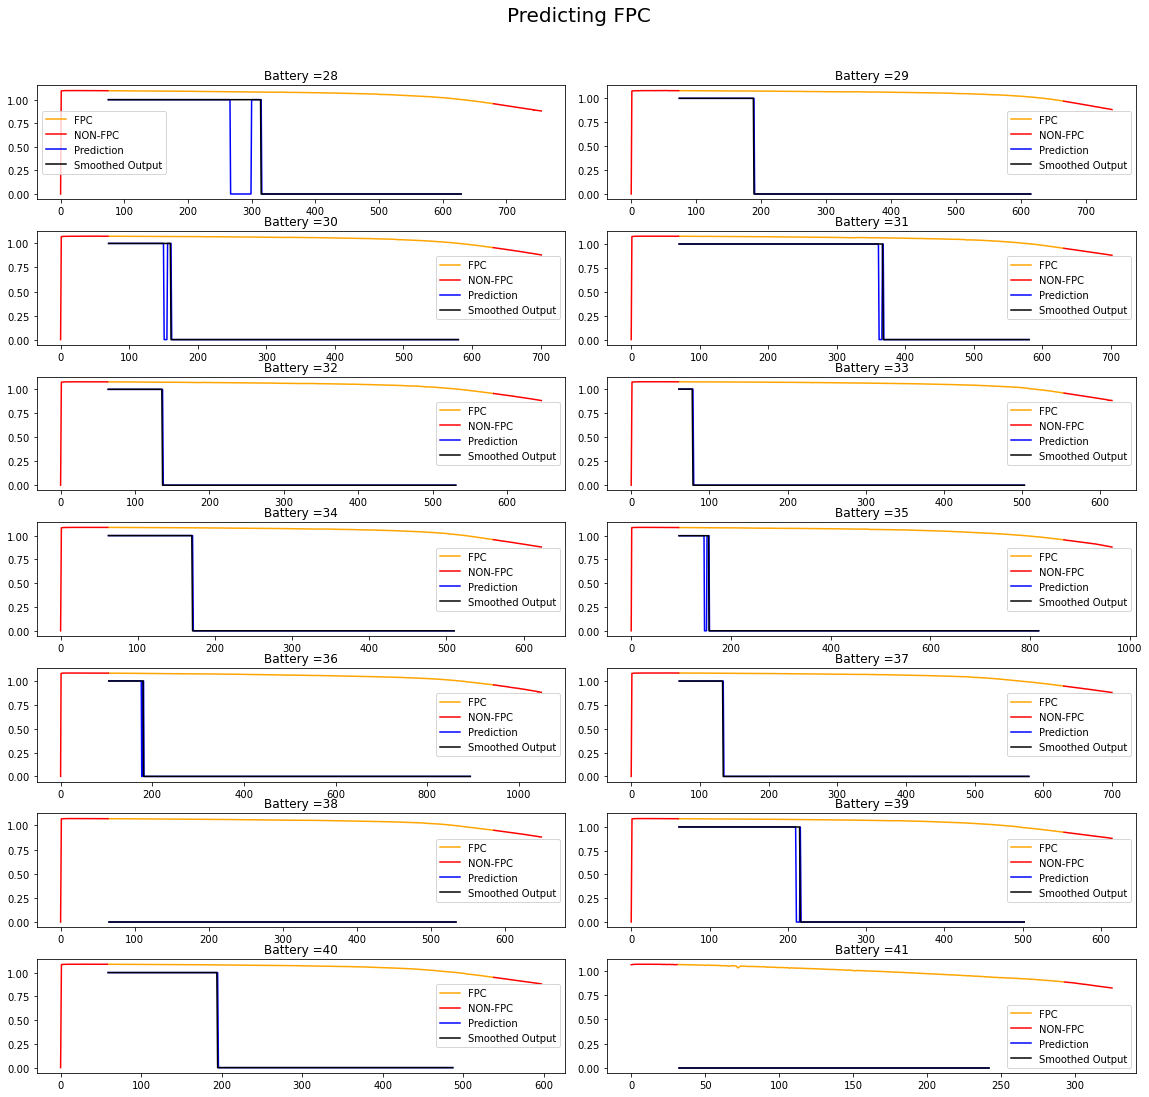

In [13]:
model.eval()
batteries_to_show = [i for i in range(28,28+14)]
window = 0
pred = []

rows = 2
col  = 7
fig, ax = plt.subplots(col,rows,figsize=(16,16))
ax = ax.flatten()
plt.suptitle("Predicting FPC", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
change_percentage_train = []
change_indices = []
for ind,battery in enumerate(batteries_to_show):
    pred = []
    count = 0
    for x, y ,_ in FPC_dataloader:
        initial_count = count
        if(_[0][7:] == str(battery)):
            out = torch.where(model(x) > 0.5, 1, 0)
            pred.append(out)
            count = count +1
        
        if(initial_count==count and count >1):
            break
    # print(len(pred)- len(discharge_capacities[battery][0])*0.80)
    index, smoothed_output = get_fpc_window(pred, patiance=200)   # Index where the the transition occurs
    index = index*stride

    change_indices.append(index)
    
    change_percentage = 100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0])
    
    change_percentage_train.append(change_percentage)


    # Code for plotting the outputs
    FPC_curve = np.copy(discharge_capacities[battery][0])
    FPC_curve[1:int(percentage*len(discharge_capacities[battery][0]))] = None
    FPC_curve[int((1-percentage)*len(discharge_capacities[battery][0])):-1] = None

    Non_FPC_curve = np.copy(discharge_capacities[battery][0])
    Non_FPC_curve[int(percentage*len(discharge_capacities[battery][0])):int((1-percentage)*len(discharge_capacities[battery][0]))] = None

    pred_padded = np.pad(pred, (int(percentage*len(discharge_capacities[battery][0])), 0), constant_values=(np.nan,))
    smoothed_output_padded = np.pad(smoothed_output, (int(percentage*len(discharge_capacities[battery][0])), 0), constant_values=(np.nan,))


    ax[ind].plot(FPC_curve, color = 'orange')
    ax[ind].plot(Non_FPC_curve, color ='red')
    ax[ind].plot(pred_padded,color ='blue')
    ax[ind].plot(smoothed_output_padded,color ='black')
    
    ax[ind].legend(["FPC", "NON-FPC","Prediction","Smoothed Output"])
    

    ax[ind].set_title("Battery =" +str(battery))


In [15]:
np.mean(change_percentage_train)
print(change_percentage_train)
print(change_indices)

[99.02400216187397, 99.75816527388703, 99.84695474805584, 98.75482198933386, 99.86492068224737, 99.98486900121847, 99.79704854276714, 99.94628638814525, 99.90113195424281, 99.93954824341465, 82.15621678668172, 99.41809042215665, 99.6026508806241, 76.984337597525]
[240, 115, 91, 298, 73, 18, 109, 60, 76, 64, -1, 155, 136, -1]


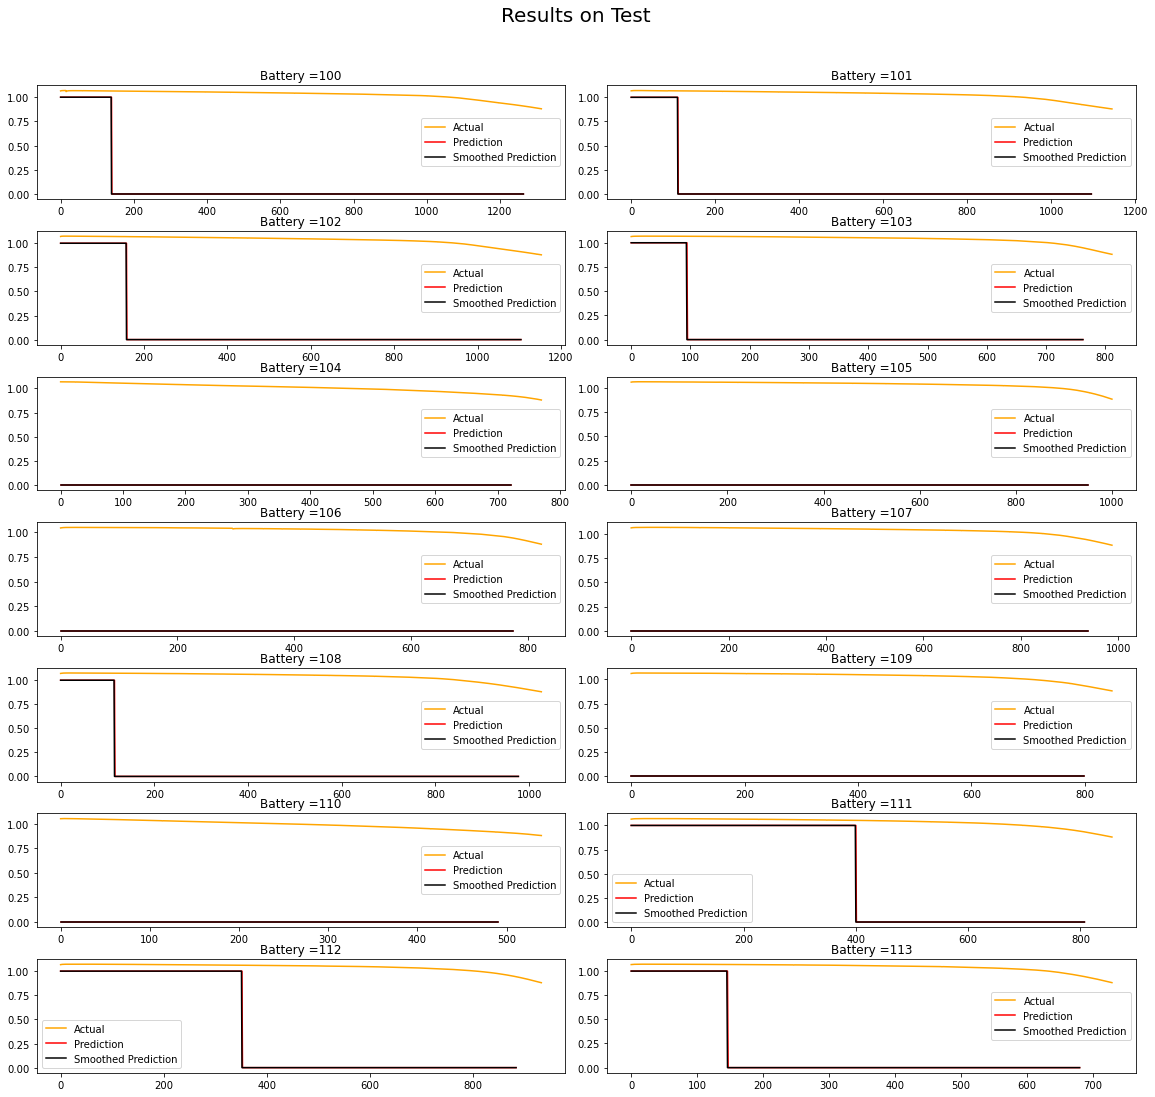

In [16]:
model.eval()
batteries_to_show = [i+100 for i in range(0,14)]
window = 0
pred = []

rows = 2
col  = 7
fig, ax = plt.subplots(col,rows,figsize=(16,16))
ax = ax.flatten()
plt.suptitle("Results on Test ", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

change_percentage_test = []
change_indices_test =[]

for ind,battery in enumerate(batteries_to_show):
    pred = []
    count = 0
    for x, y ,_ in test_dataloader:
        initial_count = count
        if(_[0][12:] == str(battery)):
            out = torch.where(model(x) > 0.5, 1, 0)
            pred.append(out)
            count = count +1
        if(initial_count==count and count >1):
            break

    index,smoothed_output = get_fpc_window(pred,patiance=10)   # Index where the the transition occurs
    index = index*stride
    change_indices_test.append(index)

    change_percentage_test.append(100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0]))
    
    
    ax[ind].plot(discharge_capacities[battery][0], color = 'orange')
    ax[ind].plot(pred, color ='red')
    ax[ind].plot(smoothed_output, color ='black')
    
    ax[ind].legend(["Actual", "Prediction", "Smoothed Prediction"])
    

    ax[ind].set_title("Battery =" +str(battery))


In [16]:
np.mean(change_percentage_test)
change_indices_test

[1264, 1095, 1104, 762, 721, 951, 774, 938, 977, 799, 490, 780, 877, 680]

In [17]:
# no_of_channels = [1,2,3,4,5,6,7]
# no_of_channels = [7]
# changes_train = []
# changes_test = []
# epochs = 2


# for channels in no_of_channels: 
#     print("Channels used : ", channels)
#     percentage  = 0.10  # 5 percent data
#     window_size = 50    # window size
#     stride = 1          # stride

#     train_data,FPC_data = get_data(discharge_capacities[:100],percentage,window_size,stride,channels,type = "train")
#     test_data  = get_data(discharge_capacities[100:],None,window_size,stride,channels,type= "test")

#     obj_train  = battery_dataloader(train_data)
#     obj_FPC  = battery_dataloader(FPC_data)
#     obj_test  = battery_dataloader(test_data)


#     train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
#     FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
#     test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)
    
#     print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)
#     model = train_model(window_size,channels,train_dataloader,epochs)


#     model.eval()
#     change_percentage_train = []
#     batteries =[i for i in range (100)]
#     change_indices = []
    
#     for ind,battery in enumerate(batteries):
#         pred = []
#         count = 0
#         for x, y ,_ in FPC_dataloader:
#             initial_count = count
#             if(_[0][7:] == str(battery)):
#                 out = torch.where(model(x) > 0.5, 1, 0)
#                 pred.append(out)
#                 count = count +1
            
#             if(initial_count==count and count >1):
#                 break
#         # print(len(pred)- len(discharge_capacities[battery][0])*0.80)
#         index, smoothed_output = get_fpc_window(pred, patiance=200)   # Index where the the transition occurs
#         index = index*stride

#         change_indices.append(index)
        
#         change_percentage = 100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0])
        
#         change_percentage_train.append(change_percentage)

#     print(change_indices)
    
#     batteries_to_show = [i+100 for i in range(0,24)]
#     for ind,battery in enumerate(batteries_to_show):
#         pred = []
#         count = 0
#         for x, y ,_ in test_dataloader:
#             initial_count = count
#             if(_[0][12:] == str(battery)):
#                 out = torch.where(model(x) > 0.5, 1, 0)
#                 pred.append(out)
#                 count = count +1
#             if(initial_count==count and count >1):
#                 break
        
#         index = stride*get_fpc_window(pred)   # Index where the the transition occurs
#         change_percentage_test.append(100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0]))

#     changes_train.append(np.mean(change_percentage_train))
#     changes_test.append(np.mean(change_percentage_test))

# import pandas as pd
# results = pd.DataFrame([changes_train,changes_test], columns=no_of_channels, index=["Train","Test"])
# results.to_csv('channel_analysis.csv')

In [18]:
# indices where change happen ...
charge_indices =[1429, 1677, 1738, 1095, 1316, 807, 457, 645, 791, 579, 653, 524, 637, 634, 501, 579, 375, 396, 759, 762, 631, 645, 621, 637, 682, 516, 649, 533, 554, 541, 510, 511, 467, 442, 448, 721, 789, 509, 469, 441, 428, 210, 85, 320, 237, 325, 355, 385, 426, 353, 341, 365, 357, 369, 367, 341, 373, 365, 381, 398, 368, 339, 348, 345, 381, 366, 355, 365, 384, 386, 370, 338, 397, 350, 339, 333, 373, 310, 342, 339, 333, 360, 309, 545, 756, 798, 840, 787, 611, 482, 1417, 611, 780, 811, 602, 693, 601, 635, 649, 1259]

In [19]:
def get_data_RUL(discharge_capacities,charge_indices, window_size,stride,channels):
        
        train_data =[]

        for index,battery in enumerate(discharge_capacities):
                battery = np.array(battery)
                battery_name = "battery" + str(index)
                i = charge_indices[index]
                
                while(i+stride+window_size+1 <= int(len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                        train_data.append((battery[:channels,i:i+window_size], battery[0,i+window_size],battery_name ))
                        i = i+stride
                                                                        
        return train_data

In [20]:
import math
class CNN_Model_RUL(nn.Module):
    
    def __init__(self,input_size, channels):
        super(CNN_Model_RUL, self).__init__()
        self.name = "CNN"
        filter_size_1 = 5
        filter_size   = 5
        
        self.conv1 = nn.Conv1d(channels,16,kernel_size = filter_size_1, stride=1,padding=filter_size_1//2)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.max_pool1 = nn.MaxPool1d(2)
        

        self.conv2 = nn.Conv1d(16,32, kernel_size = filter_size_1, stride = 1,padding=filter_size_1 //2)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.max_pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32,64, kernel_size = filter_size, stride = 1,padding=filter_size //2)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.max_pool3 = nn.MaxPool1d(2)

       
        self.flatten_size = 128*math.floor(input_size/(2*2*2*2))
        self.flatten = nn.Flatten(start_dim=1)
        
        self.Linear1 = nn.Linear(self.flatten_size, input_size)
        self.batch_norm_linear = nn.BatchNorm1d(input_size)
        # self.a = nn.Linear()
        self.Linear2 = nn.Linear(input_size,1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        # print(self.flatten_size)
        
        
        
    def forward(self,x):
        # x= x.view(x.shape[0],1,x.shape[1])
        
        out = self.conv1(x)
        # out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        # out = self.relu(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.max_pool2(out)   

        # out = self.conv3(out)
        # out = self.relu(out)
        # out = self.batch_norm3(out)
        # out = self.dropout(out)
        # out = self.max_pool3(out) 

        out = self.flatten(out)
        
        out = self.Linear1(out)  
        out = self.Linear2(out)

        return out

In [21]:
class LSTM_Model_RUL(nn.Module):
    
    def __init__(self,input_size,channels):
        super(LSTM_Model_RUL, self).__init__()
        self.name = "LSTM"
        hidden_size1 = input_size
        hidden_size2 = input_size
        
        num_layers = 4
        self.LSTM1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size1, num_layers = num_layers,batch_first=True)
        self.LSTM2 = nn.LSTM(input_size = input_size, hidden_size = hidden_size2, num_layers = num_layers,batch_first=True)

        self.flatten = nn.Flatten()
        self.Linear1 = nn.Linear(hidden_size2,128)
        self.Linear2 = nn.Linear(128,50)
        self.Linear3 = nn.Linear(50,1)
        self.relu    = nn.ReLU()

    def forward(self,x):
        
        # self.h0 = torch.randn(4, x.size(0), 100)
        # self.c0 = torch.randn(4, x.size(0), 100)
        
        # x= x.view(x.shape[0],channels,x.shape[1])
        # out, (hn, cn) = self.LSTM(x, (self.h0, self.c0))

        out, (_, _) = self.LSTM1(x)
        out,(_,_) = self.LSTM2(out)
        
        out = self.flatten(out)
        out = self.relu(out)
        out = self.Linear1(out)
        out = self.relu(out)
        out = self.Linear2(out)
        out = self.relu(out)
        out = self.Linear3(out)


        return out

In [22]:
class battery_dataloader_RUL(Dataset):
    
    def __init__(self,data):
        self.data = data
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        inp =  torch.tensor(self.data[idx][0]).float()
        output = torch.tensor(self.data[idx][1]).float()
        battery_name = self.data[idx][2]
        
        return inp, output, battery_name

In [23]:
channels = 1
window_size = 50
stride =1
train_data= get_data_RUL(discharge_capacities[:100],charge_indices,window_size,stride,channels)

obj_train  = battery_dataloader_RUL(train_data)
train_dataloader = DataLoader(obj_train, batch_size=128,shuffle=False)

In [24]:
from torchmetrics.classification import BinaryAccuracy


def train_model_RUL(window_size,channels,train_dataloader,epochs):

    model = LSTM_Model_RUL(window_size,channels)
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
    criterion = nn.MSELoss()
    # metric = BinaryAccuracy()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

   

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        model.requires_grad_(True)
        acc = 0
        total_loss = 0
        total = 0
        total_batches = 0
        for x, y ,_ in train_dataloader:
            
            x = x.to(device=device)
            y = y.to(device=device)
            out = model(x)
            
            loss = criterion(out,y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size()[0]
            total += x.size()[0]
            total_batches +=1


        print("Epoch = {}, Loss = {} ".format(epoch, total_loss/total))
    return model

In [25]:
model_RUL = train_model_RUL(window_size, channels,train_dataloader,100) 

Epoch = 0, Loss = 0.1720333945361493 
Epoch = 1, Loss = 0.0019640351817637024 
Epoch = 2, Loss = 0.0019587590298847687 
Epoch = 3, Loss = 0.0020139979202420917 
Epoch = 4, Loss = 0.0021079392817122465 
Epoch = 5, Loss = 0.0021242732699033764 
Epoch = 6, Loss = 0.0021228386514100515 
Epoch = 7, Loss = 0.0021192657400376735 
Epoch = 8, Loss = 0.0021145530788829105 
Epoch = 9, Loss = 0.0021090854878183843 
Epoch = 10, Loss = 0.0021032299244297015 
Epoch = 11, Loss = 0.0020973367153488158 
Epoch = 12, Loss = 0.002091425512589669 
Epoch = 13, Loss = 0.002085704605261539 
Epoch = 14, Loss = 0.002080027464664008 
Epoch = 15, Loss = 0.0020747423390136384 
Epoch = 16, Loss = 0.0020694317714119504 
Epoch = 17, Loss = 0.0020643893602237395 
Epoch = 18, Loss = 0.002059446932359678 
Epoch = 19, Loss = 0.002054893148974997 
Epoch = 20, Loss = 0.0020504419253736016 
Epoch = 21, Loss = 0.0020462837797870503 
Epoch = 22, Loss = 0.0020419027292956347 
Epoch = 23, Loss = 0.00203797209590703 
Epoch = 24, 

In [26]:
battery_data = np.array(discharge_capacities[1])[:1,charge_indices[0]:]
model_RUL.eval()
i =0
last_window = np.reshape(battery_data[:,0:window_size], (1,1,window_size))

outs =[]    
while(i!=800): 
    out = model_RUL(torch.tensor(last_window).float()).item()
    last_window = np.append(last_window,out)
    last_window = np.reshape(last_window[-window_size:],(1,1,50))
    outs.append(out)
    i = i+1 

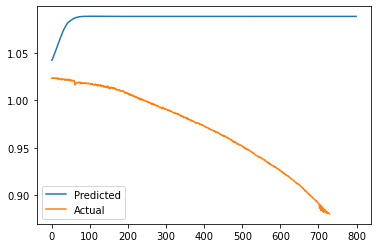

In [27]:
plt.plot(outs)
plt.plot(discharge_capacities[1][0][charge_indices[0]:])
plt.legend(["Predicted","Actual"])